# Natural Language Processing with Disaster Tweets

Notebook created for Kaggle Disaster Tweets competition.<br>
https://www.kaggle.com/c/nlp-getting-started


This notebook uses:
- pandas - load and display data
- numpy - operations on numbers
- matplotlib - plot data
- re, string and nltk - operations on text
- sklearn - data preprocessing
- keras and tensorflow - build neural network model and get predicions

## Import modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Load and show data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data preprocessing

In [4]:
# Drop location column
train = train.drop(columns=['location'])
test = test.drop(columns=['location'])

In [5]:
def clean_text(text):
    """Return text"""
    
    # Replace @user_name with word 'user'
    text = re.sub(r'@\S+', r'user', text)
    
    # Replace number with word 'number'
    text = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', r'number', text)
    
    # Remove punctuations
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)

    # Replace url with word 'url'
    text = re.sub(r"http\S+", 'url', text)
    
    # Remove stopwords e.g. "a", "to", "of"
    text = ' '.join([word.lower() for word in text.split() if not word in stopwords.words('english')])
    
    # Lematize words: "dogs" --> "dog"
    lemmer = WordNetLemmatizer()
    text = ' '.join([lemmer.lemmatize(word) for word in text.split(' ')])
    
    return text

In [6]:
# Cleaning text
train['text'] = [clean_text(row['text']) for _, row in train.iterrows()]
test['text'] = [clean_text(row['text']) for _, row in test.iterrows()]

train.head()

,id,keyword,text,target
0,1,NaN,our deed reason earthquake may allah forgive u,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,all resident asked shelter place notified offi...,1
3,6,NaN,number people receive wildfire evacuation orde...,1
4,7,NaN,just got sent photo ruby alaska smoke wildfire...,1


In [7]:
test.head()

,id,keyword,text
0,0,NaN,just happened terrible car crash
1,2,NaN,heard earthquake different city stay safe ever...
2,3,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,apocalypse lighting spokane wildfire
4,11,NaN,typhoon soudelor kill number china taiwan


## Data vectorization with CountVectorizer

In [8]:
def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect.toarray(), count_vectorizer

X_train_count, count_vectorizer = count_vector(train['text'])
x_test_submission = count_vectorizer.transform(test['text']).toarray()

print(f'X_train_count shape: {X_train_count.shape}')
print(f'x_test_submission shape: {x_test_submission.shape}')

X_train_count shape: (7613, 13668)
x_test_submission shape: (3263, 13668)


## Prepare data to training

In [9]:
y = train['target']
x = X_train_count

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

## Defining Neural Network

In [10]:
input_dim = x_train.shape[1]

# Define neural network with one hidden layer
model = Sequential()
model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                874816    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 874,881
Trainable params: 874,881
Non-trainable params: 0
_________________________________________________________________


## Training Neural Network

In [11]:
# Stop training when metric has stopped improving and restore best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

# Train model with early stopping
history = model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    verbose=False)

## Plot Loss and Accuracy function

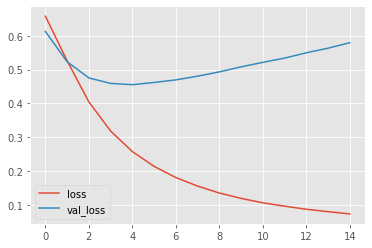

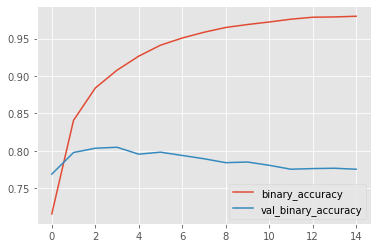

In [12]:
plt.style.use('ggplot')

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [13]:
print(f'Validation Binary Accuracy: {round(max(history.history["val_binary_accuracy"]) * 100, 2)} %')

Validation Binary Accuracy: 80.47 %


## Predict from test dataset

In [14]:
predictions = model.predict_classes(x_test_submission)
predictions = np.reshape(predictions, (predictions.shape[0]))

## Save predictions to csv file

In [15]:
sample_sub = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Kaggle results

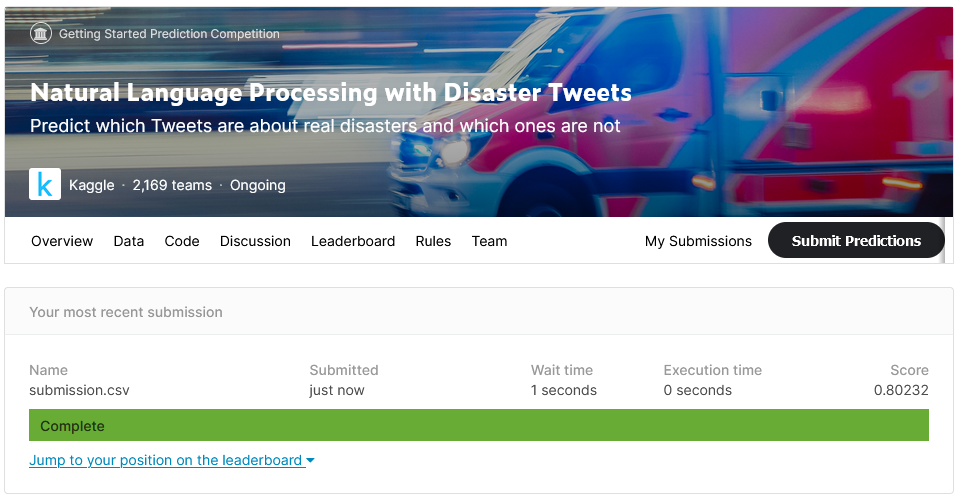

Model classified 80,232 % cases well. It is a very good score, but can be improved by changing model, vectorisation or preprocessing method.